# Download dataset

In [1]:
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp" -O data && rm -rf /tmp/cookies.txt
!unzip -q data && rm data

replace lfw2/lfw2/Aaron_Eckhart/Aaron_Eckhart_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Imports

In [1]:
# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Subtract
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Dropout, BatchNormalization

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Utils
import pandas as pd
import numpy as np
import cv2
import os
import joblib
import time
import random
import itertools

data_path = 'lfw2/lfw2/'

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 2.c. Exploratory Data Analysis (EDA)



The dataset called "Labeled Faces in the Wild-a (LFW-a)" is an image collection of labeled, face images intended for studying Face Recognition in unconstrained images. In this project we will use this dataset in order to create a model that hopefully will learn to decide if two images are of the same person using Siamese architecture

In [3]:
people_list = os.listdir(data_path)
print(f'The dataset contains images of {len(people_list)} different people')
images_cnt = [len(os.listdir(f'{data_path}/{people}')) for people in people_list]
print(f'Each people have {np.mean(images_cnt):.3f} +- {np.std(images_cnt):.3f} images')
print(f'With maximum of {np.max(images_cnt)} per people and minimum of {np.min(images_cnt)}')

The dataset contains images of 5749 different people
Each people have 2.302 +- 9.016 images
With maximum of 530 per people and minimum of 1


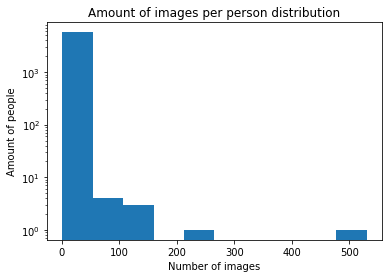

In [6]:
_ = plt.hist(images_cnt)
_ = plt.yscale('log')
_ = plt.title('Amount of images per person distribution')
_ = plt.xlabel('Number of images')
_ = plt.ylabel('Amount of people')

In [4]:
def get_image_path(name, index):
    return f'{data_path}{name}/{name}_{str(index).rjust(4, "0")}.jpg'

def load_image(image_path):
    img = cv2.imread(image_path)/255
    img = (cv2.resize(img, (105, 105)))
    return img

In [5]:
def read_dataset_part(set_type, part_type):
    name1 = 'Name' if part_type == 'same' else 'Name1'
    name2 = 'Name' if part_type == 'same' else 'Name2'
    
    part_meta = pd.read_excel('datasplit.xls', f'{set_type}_{part_type}')
    part_data = [], []
    for _, row in part_meta.iterrows():
        img1_path = get_image_path(row[name1], row['ID1'])
        img1 = load_image(img1_path)
        part_data[0].append(img1)
        img2_path = get_image_path(row[name2], row['ID2'])
        img2 = load_image(img2_path)
        part_data[1].append(img2)
        
    return [np.array(data) for data in part_data]

def read_dataset(set_type):

    same_data = read_dataset_part(set_type, 'same')
    diff_data = read_dataset_part(set_type, 'diff')
    x_data = [np.concatenate([s, d]) for s, d in zip(same_data, diff_data)]
    y_data = np.concatenate([np.ones(same_data[0].shape[0]), np.zeros(diff_data[0].shape[0])])
    
    return x_data, y_data

In [6]:
train_x, train_y = read_dataset('train')
val_x, val_y = read_dataset('val')
test_x, test_y = read_dataset('test')

In [8]:
print(f'The dataset was reorganized into couples of images, each couple labeled as `same` or `different`')
print(f'Furthermore it was splitted into train and test subsets')
print(f'The train contains {train_x[0].shape[0]+val_x[0].shape[0]} where {int(sum(train_y)+sum(val_y))} of them labeled as `same`')
print(f'The test contains {test_x[0].shape[0]} where {int(sum(test_y))} of them labeled as `same`')
print(f'We splitted the train subset into train and validation sets where the validation set contains about 20% of the train set')
print(f'Should be noted that there is no single person that is being part of more than one set')

The dataset was reorganized into couples of images, each couple labeled as `same` or `different`
Furthermore it was splitted into train and test subsets
The train contains 2200 where 1100 of them labeled as `same`
The test contains 1000 where 500 of them labeled as `same`
We splitted the train subset into train and validation sets where the validation set contains about 20% of the train set
Should be noted that there is no single person that is being part of more than one set


In [41]:
def plot_twin_images(img1, img2, label):
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,8))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.suptitle(f'The images below are labeled as {label}', y=0.75)
    
    for i, img in enumerate([img1, img2]):
            ax[i].axis('off')
            ax[i].imshow(img)
            
def plot_samples(data_x, data_y, n_samples):
    samples_idx = random.sample(range(*data_y.shape), n_samples)
    
    for idx in samples_idx:
        label = 'same' if data_y[idx] else 'different'
        plot_twin_images(data_x[0][idx], data_x[1][idx], label)

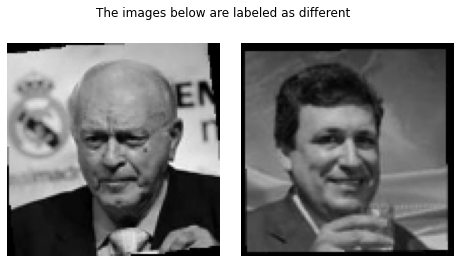

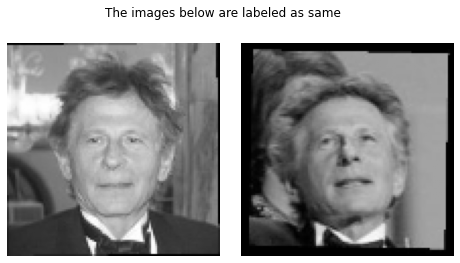

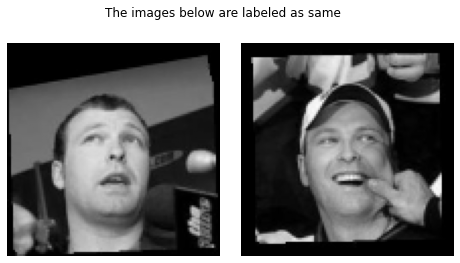

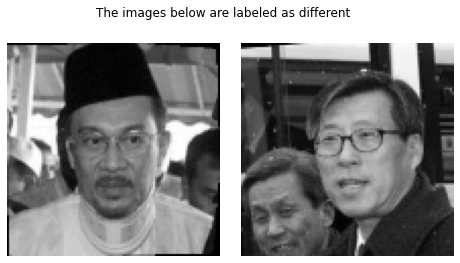

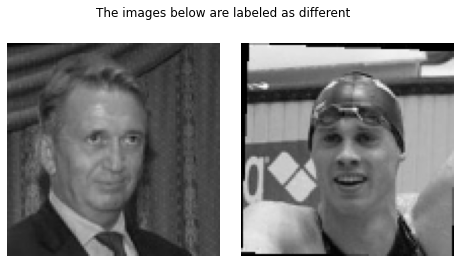

In [64]:
plot_samples(train_x, train_y, 5)

# Task 3 - Siamese network



Our Model is built from 2 Parts: The **'Feature Extraction'** and then the **'Image Comparing'** part.

'Feature Extraction' Part - This part is responsible to extract features from each image seperatly, and output a 'Feature Vector'.

'Image Comparing' Part - This part is responsible to compare the two 'Feature Vectors' (the outputs from the first part).


### **Task 3.a - 'Feature Extraction' Part Architecture**




This part consisting of 9 layers (including the input and the output layer).


**Number Of layers, dimensions, filter -** described in detail in the summary below. 


**Regularization Methods -** Droput (drop 50%) in all layers except of the input layer and on the layer prior to the Dense layer (the layer that outputs the feature vector). On the Dense layer we used a 'L2' reuglarization with value of '0.01'.


**BatchNormalization** -  we used a BatchNormalization on the same layers that we perform dropout

In [14]:
sm = 0

def siamese_model(length, params_dict):
    
    
    global sm
    inp = Input(shape=length)
    X = Conv2D(64, 10, activation='relu')(inp)
    X = BatchNormalization()(X)
    X = MaxPool2D()(X)
    X = Dropout(params_dict['dropout'])(X)
    X = Conv2D(128, 7, activation='relu')(X)
    X = BatchNormalization()(X)
    X = MaxPool2D()(X)
    X = Dropout(params_dict['dropout'])(X)
    X = Conv2D(128, 4, activation='relu')(X)
    X = BatchNormalization()(X)
    X = MaxPool2D()(X)
    X = Dropout(params_dict['dropout'])(X)
    X = Conv2D(256, 4, activation='relu')(X)
    X = Flatten()(X)
    X = Dense(4096, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(params_dict['l2_reg']))(X)
    
    sm += 1
    
    return Model(inp, X, name=f'siamese_model_{sm}')

In [11]:
siamese_model(train_x[0].shape[1:]).summary()

Model: "siamese_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 64)        19264     
_________________________________________________________________
batch_normalization_3 (Batch (None, 96, 96, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
batch_normalization_4 (Batch (None, 42, 42, 128)   

### **Task 3.a - 'Image Comparing'  Architecture**


***Input layers -*** Two input layers, each one of size 105x105x3. These layers represents the two images we are trying to compare. Each input is being fed to the same Feature Extraction part and transformed into a feature vector.

***Calculation layers*** perform L1 distance between the feature vectors (substract and abs of the vectors). 

***DropOut*** - performed on the L1 distance vector, keeping 50% of neruons.

***Dense layer*** - size: 1024. using sigmoid activation.

***Output Dense layer*** - size: 1. using sigmoid activation function and 'L2' regularization with value of 0.1.

**loss function** - 'binary_crossentropy'


In [15]:
def init_siamese_model(image_shape, output_shape=1, params_dict=None):
    input_1 = Input(shape=image_shape)
    input_2 = Input(shape=image_shape)
    
    
    sm = siamese_model(image_shape, params_dict)

    vector_1 = sm(input_1)
    
    vector_2 = sm(input_2)
    
    sub = Subtract()([vector_1, vector_2])
    d = tf.math.abs(sub)
    
    x = Dropout(params_dict['dropout'])(d)
    x = Dense(1024, activation="sigmoid")(x)
    out = Dense(output_shape, activation="sigmoid", name = 'out', kernel_regularizer=tf.keras.regularizers.l2(params_dict['l2_reg']))(x)

    model = Model([input_1, input_2], out)

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=params_dict['lr']), metrics=['acc'])#, metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    
    return model

### **Task 3.a - Learning Rate And Optimization**

***Early Stopping*** - 
We used 'EarlyStopping' that stop training when a monitored metric has stopped improving. in our case we choosed the 'monitored metric' to be **accuracy**.

***ReduceLROnPlateau -*** Reduce learning rate when a metric has stopped improving. we choose to monitor the val_loss, and min bound of lr to be 1e-6.

***Optimizer*** - Adam


In [30]:
def get_callbacks(model_name):
#     acc = 'val_loss'
#     acc_mode = 'min'
    acc = 'val_acc'
    acc_mode = 'max'
    
    checkpoint = ModelCheckpoint(
                              fr'./models/{model_name}.h5', 
                              monitor=acc, 
#                               verbose=1, 
                              save_best_only=True, 
                              mode=acc_mode)
    earlystop = EarlyStopping(monitor=acc, mode=acc_mode, verbose=0, patience=6)
    reduceLR = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 5,
                            factor = 0.5, min_lr = 1e-6, verbose = 0)

    return [checkpoint, reduceLR]#, earlystop]

In [27]:

def train_model(model_gen, train_data, val_data, batch_size=16, use_saved=False, params_dict=None):
    os.makedirs('./models', exist_ok=True)
    params = ''
    if params_dict is not None:
        params = '_'.join(f'{key}_{val}' for key,val in params_dict.items())
    model_name = model_gen.__name__[5:] + f'_{params}'
        
    if use_saved:
        history = joblib.load(fr'./models/{model_name}_history.sav')
    else:
        callbacks = get_callbacks(model_name)
        
        train_x, train_y = train_data
        
        model = model_gen(train_x[0].shape[1:], params_dict=params_dict)
        history = model.fit(
                            x=train_x,
                            y=train_y,
                            batch_size=params_dict['batch_size'],
                            epochs=params_dict['epochs'],
                            validation_data=val_data,
                            callbacks=callbacks,
                            verbose=0
                            )
        
        history = history.history
        joblib.dump(history, fr'./models/{model_name}_history.sav')
    
    model = load_model(fr'./models/{model_name}.h5')
    
    return model, history

### **Task 3.b - Reasoning Behind Choices**

**Task 3.b - Reasoning Behind Choices 'Feature Extraction' Part** 

**Architecture**


>***Number Of Layers and Dimensions*** - We reconstruct the architecture as presented in the paper. we also resized the original images' size from 250 x 250 to 105 x 105 to comply with the architecture in the paper.


**Regularization**


> ***Dropout*** - we used dropout becuase our model over-fitted. as we learned in class dropout can help reduce the problem of over-fitting.


> ***L2 regularization*** - the reason for using this regularization technique is also because of the model over-fitting. we used value of 0.01, because we saw that in the paper they used this value on their expirements. 



> ***BatchNormalization*** - We used batchNormalization because our model overfitted and batchNormalization is a technique to regularization.




**Task 3.b - Reasoning Behind Choices 'Image Comparing' Part**

**Architecture**

> ***Calculations Layer*** - we performed the L1 distance on the feature vectors as presented in the paper.

> ***Dense*** - In the paper this layer doesn't exist. In our expirements, without this layer the model didn't acheived high accuracy on the training set (the model was not able to learn fully). we thought that adding more dense layer and making the model deeper will help it to learn.

**Regularization**


> ***Dropout***- we used dropout because our model overfitted. we keep 50% of neurons because it is the recommneded value as learned in class.



> ***L2 regularization*** - the reason for using this regularization technique is also because of the model over-fitting. we used value of 0.01, because we saw that in the paper they used this value on their expirements. 


**Loss Function**



> ***binary_crossentropy*** - we used this function because in the paper they also used the 'crossEntropy' loss function, and because it is very intutitive (we try to classifiy if 2 images are same or not thus binary_crossentrpy seems to fit).



# Task 4 Performance

## Task 4.a - Convergence times, final loss and accuracy on the test set and holdout set

In [11]:
def visualize_perf(history):
    fig, ax = plt.subplots(ncols=2, figsize=(5*2,5))
    fig.suptitle(f'Model performance over epochs')
    
    for k in ['loss', 'val_loss']:
        ax[0].plot(history[k])
        
    ax[0].legend(['train_loss', 'val_loss'])
    ax[0].margins(0.01)
    ax[0].set_title('binary crossentropy')
    
    for k in ['acc', 'val_acc']:
        ax[1].plot(history[k])
        
    ax[1].legend(['train_acc', 'val_acc'])
    ax[1].margins(0.01)
    ax[1].set_title('accuracy')
    
    plt.show()


In [37]:
start = time.time()
siam_model, siam_history = train_model(init_siamese_model,
                                       (train_x, train_y),
                                       (val_x, val_y),
                                       batch_size=128,
                                       use_saved=False)
end = time.time()

Epoch 1/20
17/17 [==============================] - 8s 469ms/step - loss: 24.2504 - acc: 0.5103 - val_loss: 3.6797 - val_acc: 0.5000 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - 8s 468ms/step - loss: 2.2229 - acc: 0.5651 - val_loss: 1.8657 - val_acc: 0.5980 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - 8s 463ms/step - loss: 1.5648 - acc: 0.6204 - val_loss: 1.1782 - val_acc: 0.6730 - lr: 0.0010
Epoch 4/20
17/17 [==============================] - 8s 469ms/step - loss: 1.0780 - acc: 0.6747 - val_loss: 1.0090 - val_acc: 0.7070 - lr: 0.0010
Epoch 5/20
17/17 [==============================] - 2s 145ms/step - loss: 1.0379 - acc: 0.6857 - val_loss: 1.0540 - val_acc: 0.6710 - lr: 0.0010
Epoch 6/20
17/17 [==============================] - 7s 431ms/step - loss: 1.0755 - acc: 0.6862 - val_loss: 1.0411 - val_acc: 0.7120 - lr: 0.0010
Epoch 7/20
17/17 [==============================] - 8s 460ms/step - loss: 1.0207 - acc: 0.7141 - val_loss: 0.9816 - val_acc: 0.72

In [39]:
print(f'The model was fitted in {end - start:.2f} seconds')

The model was fitted in 108.43 seconds


In [44]:
train_stats = siam_model.evaluate(train_x, train_y, verbose=0)
print(f'Train loss: {train_stats[0]:.4f} , Train Accuracy: {train_stats[1]*100:.2f}%')
val_stats = siam_model.evaluate(val_x, val_y, verbose=0)
print(f'Validation loss: {val_stats[0]:.4f} , Validation Accuracy: {val_stats[1]*100:.2f}%')
test_stats = siam_model.evaluate(test_x, test_y, verbose=0)
print(f'Test loss: {test_stats[0]:.4f} , Test Accuracy: {test_stats[1]*100:.2f}%')

Train loss: 0.7347 , Train Accuracy: 88.42%
Validation loss: 0.8907 , Validation Accuracy: 75.63%
Test loss: 0.9081 , Test Accuracy: 75.70%


## Task 4.b - graphs describing the loss on the training set throughout the training process

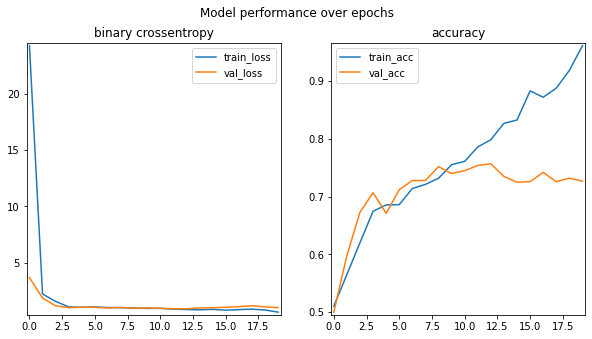

In [38]:
visualize_perf(siam_history)

## Task 4.c - Performance when experimenting with the various parameters

In [24]:
lr_lst = [0.001, 0.0001]
L2_reg_lst  = [0, 0.1, 0.001]
dropout_lst = [0.3, 0.4, 0.5]
epochs_lst = [10, 20, 30]
batch_size_lst = [32, 64, 128]
combinations = list(itertools.product(lr_lst, L2_reg_lst, dropout_lst, epochs_lst, batch_size_lst))
combinations_len = len(combinations)

In [31]:
keys = ['lr', 'l2_reg', 'dropout', 'epochs', 'batch_size']
i = 0
best_model_params = {}
best_model_acc = 0
for combination in combinations:
    i += 1
    print(f'{i} out of {combinations_len}')
    params_dict =  {keys[i]: combination[i] for i in range(len(combination))}
    siam_model, _ = train_model(init_siamese_model, (train_x, train_y),(val_x, val_y), use_saved=False, params_dict=params_dict) 
    val_loss, val_acc = siam_model.evaluate(val_x, val_y, verbose=0)
    if val_acc > best_model_acc:
        best_model_acc = val_acc
        best_model_params = params_dict
    print(f'Parameters: {params_dict},  Validation loss: {val_loss:.4f} , Validation Accuracy: {val_acc*100:.2f}%')
    

1 out of 162
Parameters: {'lr': 0.001, 'l2_reg': 0, 'dropout': 0.3, 'epochs': 10, 'batch_size': 32},  Validation loss: 0.6110 , Validation Accuracy: 71.43%
2 out of 162
Parameters: {'lr': 0.001, 'l2_reg': 0, 'dropout': 0.3, 'epochs': 10, 'batch_size': 64},  Validation loss: 0.5252 , Validation Accuracy: 77.31%
3 out of 162
Parameters: {'lr': 0.001, 'l2_reg': 0, 'dropout': 0.3, 'epochs': 10, 'batch_size': 128},  Validation loss: 0.6010 , Validation Accuracy: 72.27%
4 out of 162
Parameters: {'lr': 0.001, 'l2_reg': 0, 'dropout': 0.3, 'epochs': 20, 'batch_size': 32},  Validation loss: 0.5438 , Validation Accuracy: 77.31%
5 out of 162
Parameters: {'lr': 0.001, 'l2_reg': 0, 'dropout': 0.3, 'epochs': 20, 'batch_size': 64},  Validation loss: 0.5799 , Validation Accuracy: 70.59%
6 out of 162
Parameters: {'lr': 0.001, 'l2_reg': 0, 'dropout': 0.3, 'epochs': 20, 'batch_size': 128},  Validation loss: 0.5012 , Validation Accuracy: 78.15%
7 out of 162
Parameters: {'lr': 0.001, 'l2_reg': 0, 'dropout':

In [32]:
print(f'best params: {best_model_params} achieving {best_model_acc*100:.2f}% accuracy')

best params: {'lr': 0.001, 'l2_reg': 0.1, 'dropout': 0.3, 'epochs': 30, 'batch_size': 64} achieving 85.71% accuracy
